In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import os
import torch.nn as nn
import torch.nn.functional as F
import math

torch.set_default_tensor_type(torch.DoubleTensor)

%matplotlib inline

# Experiment 1: Embed Even Symmetry

#### Test the simple idea suggested in https://arxiv.org/pdf/1904.08991.pdf

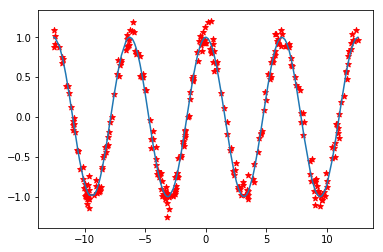

In [57]:
# generate data
def cos_data_noisy(n = 300, x_min = -4 * np.pi, x_max = 4*np.pi, eps=0.1):
    xx = np.random.uniform(x_min, x_max, n)
    cos_data = np.cos(xx)
    noise = np.random.normal(scale = 0.1, size =n)
    return xx, cos_data + noise

#visualize the function
xx, data = cos_data_noisy()
plt.scatter(xx, data, color = 'r', marker = "*")
plt.plot(np.sort(xx), np.cos(np.sort(xx)))
plt.show()

In [58]:
class FeedForwardNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(FeedForwardNet, self).__init__()
        self.input = nn.Linear(D_in, H)
        self.fc1 = nn.Linear(H, H)
        self.fc2 = nn.Linear(H, H)
        self.out = nn.Linear(H, D_out)

    def forward(self, X):
        X = F.relu(self.input(X))
        X = F.relu(self.fc1(X))
        X = self.fc2(X)
        X = self.out(X)
        return X

    
class EvenSymmetryNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(EvenSymmetryNet, self).__init__()
        self.input = nn.Linear(D_in, H)
        self.fc1 = nn.Linear(H, H)
        self.fc2 = nn.Linear(H, H)
        self.out = nn.Linear(H, D_out)

    def forward(self, X):
        X_copy = X.clone()
        
        X = torch.tanh(self.input(X))
        X = torch.tanh(self.fc1(X))
        X = self.fc2(X)

        #'hub' layer
        X_oppo = torch.tanh(self.input(-X_copy))
        X_oppo = torch.tanh(self.fc1(X_oppo))
        X_oppo = self.fc2(X_oppo)

        X_even = 1/2. * (X+X_oppo)
        X_even = self.out(X_even)

        return X_even

In [59]:
num_epochs = 1000
n_train = 300
batch_size = 30
learning_rate = 1e-4

In [60]:
model = EvenSymmetryNet(1, 64, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [61]:
for epoch in range(num_epochs):
    tt, xx = cos_data_noisy(n = n_train)
    xx = torch.Tensor(xx.reshape(-1,1))
    tt = torch.Tensor(tt.reshape(-1,1))
    for i in range(int(len(xx)/batch_size)):
        tti = tt[i*batch_size:(i+1)*batch_size]
        xxi = xx[i*batch_size:(i+1)*batch_size]
        # forward
        output = model(tti)
        loss = criterion(output, xxi)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if( (epoch+1) % (num_epochs/10) ==0):
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.data))

epoch [100/1000], loss:0.5342
epoch [200/1000], loss:0.3843


KeyboardInterrupt: 

#### Note: the activation function matters and the choice of them is problem specific. 

In [472]:
tt_veri = tt.data[tt.data>0]
tt_veri = np.hstack((tt_veri,-tt_veri))
tt_veri = torch.Tensor(tt_veri.reshape(-1,1))

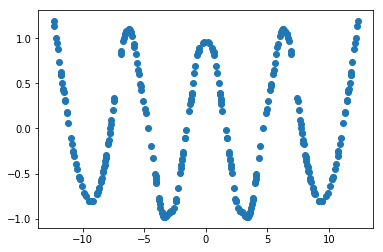

In [473]:
plt.scatter(tt_veri, model(torch.Tensor(tt_veri)).data)

# Experiment 2: Simple Pendulum

#### write solution to the initial value problem as x(t) = x(0) + NN(t) * t
#### see paper https://pdfs.semanticscholar.org/5ebb/e0b1a3d7a2431bbb25d6dfeec7ed6954d633.pdf
#### Unsupervised learning, embed Hamiltonian's equation in NN.
#### Hamilton's equation alone does not guarantee symplecticity though; 
#### can we really generalize to different starting point?? Seems necessary to train new network for each starting point for nonlinear problem

In [9]:
#Unsupervised Learning
class PendulumNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(PendulumNet, self).__init__()
        self.input = nn.Linear(D_in, H)
        self.fc1 = nn.Linear(H, H)
        self.fc2 = nn.Linear(H, H)
        self.out = nn.Linear(H, D_out)

    def forward(self, X):
        X = torch.sin(self.input(X))
        X = torch.tanh(self.fc1(X))
        X = torch.tanh(self.fc2(X))
        
        X = self.out(X)
        return X


#### Adding a layer with sinusoidal is essential

In [77]:
m = 1.
L = 1.
g = 1.
T = 10.0

theta0 = math.pi/5
p0 = 1
H0 = p0**2/(2*m*L**2) + m*g*L*(1 - np.cos(theta0))

model_pendulum = PendulumNet(1, 64, 2)

#model_pendulum_p = PendulumNet(1, 64, 1)


In [78]:
num_epochs = 50000
batch_size = 120
n_train = 600
learning_rate = 1e-5

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_pendulum.parameters(), lr = learning_rate, weight_decay=2e-6)


#### Note: first run the experiment without penalizing energy deviation in Loss; after some training add this penalization term. Otherwise the solution won't converge. 

In [79]:
regularize_energy = False
# Start training
for epoch in range(num_epochs):
    np.random.seed(0)
    tt = np.random.uniform(0, T, n_train)
    #tt = np.random.power(1.5, size = n_train) * T
    tt = torch.Tensor(tt.reshape(-1,1))
    tt.requires_grad_(True)

    for i in range(int(len(tt)/batch_size)):
        
        tti = tt[i*batch_size:(i+1)*batch_size]
        
        # forward
        theta = theta0 + model_pendulum(tti)[:,0].clone().reshape(-1,1) * tti
        p = p0 + model_pendulum(tti)[:,1].clone().reshape(-1,1) * tti
        
        #p = p0 + model_pendulum_p(tti)[:,0].clone().reshape(-1,1) * tti
        
        p.retain_grad()
        theta.retain_grad()

        #H = Hamiltonian_single_pendulum(theta, p)
        H = p**2/(2*m*L**2) + m*g*L*(1 - torch.cos(theta))
        
        
        ## use auto diff for d_H_d_p and d_H_d_theta
        d_H_d_p, = torch.autograd.grad(H, p, H.new(H.shape).fill_(1),create_graph = True)
        d_H_d_theta, = torch.autograd.grad(H, theta, H.new(H.shape).fill_(1),create_graph = True)
        
        ## or pre-compute this
        ## this also works; but the above is more 'automatic'
        #d_H_d_p = p/(m*L**2)
        #d_H_d_theta = m*g*L*torch.sin(theta)
        
        d_theta_d_t, = torch.autograd.grad(theta, tti, theta.new(theta.shape).fill_(1),create_graph = True)
        d_p_d_t, = torch.autograd.grad(p, tti, p.new(p.shape).fill_(1),create_graph = True)
        
        loss_eqn = criterion(d_p_d_t, - d_H_d_theta) + criterion(d_theta_d_t, d_H_d_p)
        
        if(regularize_energy == True):
            loss_energy = criterion(H, H.new(H.shape).fill_(H0))
            loss = loss_eqn + 1/2. * (loss_eqn.data/loss_energy.data) * loss_energy
            
        else:
            loss = loss_eqn

        optimizer.zero_grad()
        loss.backward(retain_graph = True)
        optimizer.step()
        
  
    if( (epoch+1) % (num_epochs/500) ==0 or epoch ==0):
        print('epoch [{}/{}], loss eqns of motion:{:.16f}'.format(epoch + 1, num_epochs, loss_eqn.data))
        if(regularize_energy == True):
            print('epoch [{}/{}], loss energy:{:.16f}'.format(epoch + 1, num_epochs, loss_energy.data))

epoch [1/50000], loss eqns of motion:0.6827105770753359
epoch [100/50000], loss eqns of motion:0.1334580098981028
epoch [200/50000], loss eqns of motion:0.0815803545747798
epoch [300/50000], loss eqns of motion:0.0483654024046754
epoch [400/50000], loss eqns of motion:0.0268411149940127
epoch [500/50000], loss eqns of motion:0.0144628731644238
epoch [600/50000], loss eqns of motion:0.0077505105396552
epoch [700/50000], loss eqns of motion:0.0043727184744979
epoch [800/50000], loss eqns of motion:0.0026809560161037
epoch [900/50000], loss eqns of motion:0.0017697733247832
epoch [1000/50000], loss eqns of motion:0.0012297705354525
epoch [1100/50000], loss eqns of motion:0.0008941041150094
epoch [1200/50000], loss eqns of motion:0.0006848101931890
epoch [1300/50000], loss eqns of motion:0.0005525504326982
epoch [1400/50000], loss eqns of motion:0.0004633172468448
epoch [1500/50000], loss eqns of motion:0.0003971580860779
epoch [1600/50000], loss eqns of motion:0.0003441718694417
epoch [17

#### Note: control the energy penalty term to be on the same order as the loss incurred by the eqns of motion

In [49]:
# compare with a high order symplectic integrator:
# 4th order yoshida
# this would be much more accurate but hard to construct in general
def yoshida4(thetai, vi, dt):
    c1 = 0.6756035959798289
    c2 = -0.17560359597982877
    c3 = c2
    c4 = c1
    d1 = 2*c1
    d3 = d1
    d2 = 2*(c3 - c1)
    
    thetai1 = thetai + c1 * vi * dt
    vi1 = vi + d1 * (-g/L) * np.sin(thetai1)*dt
    thetai2 = thetai1 + c2*vi1 * dt
    vi2 = vi1 + d2 * (-g/L) * np.sin(thetai2)*dt
    thetai3 = thetai2 + c3 * vi2 * dt
    vi3 = vi2 + d3 * (-g/L) * np.sin(thetai3)*dt  
    
    thetaf = thetai3 + c4 * vi3 *dt
    vf = vi3
    
    return thetaf, vf

def numerical_yoshida4(steps):
    Nstep =  steps
    dt = T/Nstep
    thetas = []
    vs = []
    theta, v = theta0, p0
    thetas.append(theta)
    vs.append(v)

    for i in np.arange(Nstep):
        theta,v = yoshida4(theta,v,dt)
        thetas.append(theta)
        vs.append(v)
    vs = np.array(vs)
    thetas = np.array(thetas)
    return vs, thetas

steps = n_train
t_numerical =  T/steps* np.arange(steps+1)
vs, thetas = numerical_yoshida4(steps)

Nstep = n_train

Text(0, 0.5, 'p_theta')

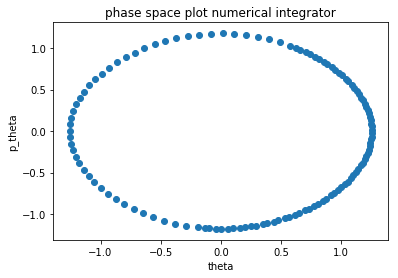

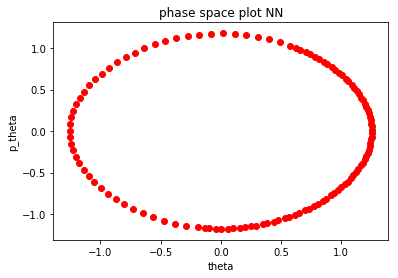

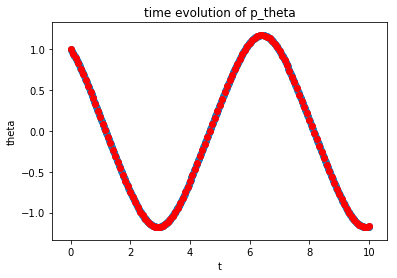

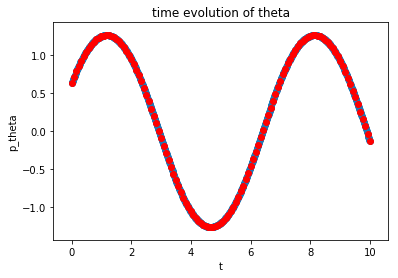

In [50]:
skip = 5

plt.figure()
plt.title('phase space plot numerical integrator')
plt.xlabel('theta')
plt.ylabel('p_theta')
plt.scatter(thetas[::skip], vs[::skip])

tt = np.arange(Nstep+1) * T/Nstep
tt = torch.Tensor(tt.reshape(-1,1))

theta =  theta0 + model_pendulum(tt)[:,0].clone().reshape(-1,1)*tt
p = p0 + model_pendulum(tt)[:,1].clone().reshape(-1,1)*tt
#p = p0 + model_pendulum_p(tt)[:,0].clone().reshape(-1,1) * tt


plt.figure()
plt.title('phase space plot NN')
plt.xlabel('theta')
plt.ylabel('p_theta')
plt.scatter(theta.detach().numpy()[::skip], p.detach().numpy()[::skip],color = 'r')


H_test = p**2/(2*m*L**2) + m*g*L*(1 - torch.cos(theta))


plt.figure()
plt.title('time evolution of p_theta')
plt.scatter(t_numerical, vs)
plt.scatter(tt[::skip], p.detach().numpy()[::skip],color = 'r',label = 'NN')
plt.xlabel('t')
plt.ylabel('theta')

plt.figure()
plt.title('time evolution of theta')
plt.scatter(t_numerical, thetas)
plt.scatter(tt[::skip], theta.detach().numpy()[::skip], color = 'r', label = 'NN')
plt.xlabel('t')
plt.ylabel('p_theta')


Text(0.5, 0, 't')

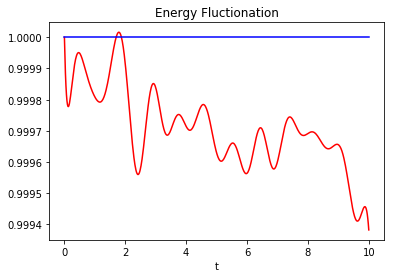

In [51]:
plt.figure()
plt.title('Energy Fluctionation')
plt.plot(tt.detach().numpy(), H_test.detach().numpy()/H0,color = 'r', label = 'NN')

H_yoshi = vs**2/(2*m*L**2) + m*g*L*(1 - np.cos(thetas))
plt.plot(t_numerical, H_yoshi/H0,color = 'b', label = 'Yoshida 4th order')
plt.xlabel('t')

#### In a simple model like the above, a numerical integrator seems better; but symplectic integrators are not trivial to construct in general

# Experiment 3: Spring Pendulum

#### 4 degress of freedom: theta, p_theta(as in the simple pendulum), and x, p_x (where x is the displacement of the end of the spring from equilibrium).

### Euler Integrator

In [52]:
m = 1.
L = 1
g = 1.
k = 1
T = 10

theta_0 = math.pi/10
p_theta_0 = 0.1
x_0 = -0.02
p_x_0 = 0.

In [259]:
steps = 80000
dt = T/steps
def spring_pendulum_euler(theta_i, p_theta_i, x_i, p_x_i ):
    
    p_theta_f = p_theta_i + dt * (-m*g*(L+x_i)*np.sin(theta_i))
    
    theta_f = theta_i + dt *(p_theta_i/(m*(L+x_i)**2))
    
    p_x_f = p_x_i + dt * (-p_theta_i**2/(m*(L+x_i)**3) - k*x_i + m*g*np.cos(theta_i))
    
    x_f = x_i + dt * (p_x_i/m)
    
    return theta_f, p_theta_f, x_f, p_x_f

thetas = []; p_thetas = []; xs = []; p_xs = [];

theta = theta_0; p_theta = p_theta_0; x = x_0; p_x = p_x_0;

thetas.append(theta); p_thetas.append(p_theta); xs.append(x); p_xs.append(p_x)

for i in range(steps):
    theta, p_theta, x, p_x = spring_pendulum_euler(theta, p_theta, x, p_x)
    thetas.append(theta); p_thetas.append(p_theta); xs.append(x); p_xs.append(p_x)

thetas = np.array(thetas); p_thetas = np.array(p_thetas); xs = np.array(xs); p_xs = np.array(p_xs)
ts = np.arange(steps + 1) * dt

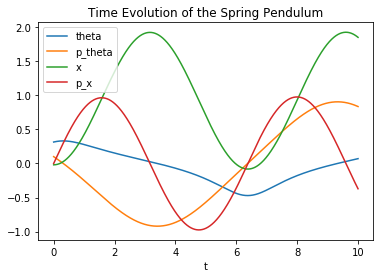

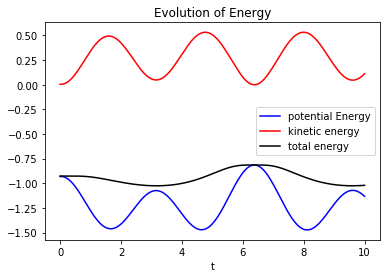

In [260]:
plt.figure()

plt.title('Time Evolution of the Spring Pendulum')

plt.plot(t, thetas, label = 'theta')
plt.plot(t, p_thetas, label = 'p_theta')
plt.plot(t, xs, label = 'x')
plt.plot(t, p_xs, label = 'p_x')
plt.xlabel('t')
plt.legend()
#################################################
plt.figure()
plt.title('Evolution of Energy')


potential = 1/2.*k*xs**2 - m*g*(L+xs)*np.cos(thetas)
kinetic = 1/2.*m*((p_xs/m)**2+ (p_thetas/((L+xs)*m)) **2 )

total_euler = potential + kinetic
H0 = total_euler[0]

t = np.arange(steps+1)*T/steps
plt.plot(t, potential,color = 'b', label = 'potential Energy')
plt.plot(t, kinetic, color = 'r', label = 'kinetic energy')
plt.plot(t, total_euler, color = 'k',label = 'total energy')

plt.xlabel('t')

plt.legend()



#### the above are numerical results using forward Euler

### NN Integrator

In [99]:
# Same as Pendulum Net..
class SpringPendulumNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(SpringPendulumNet, self).__init__()
        self.input = nn.Linear(D_in, H)
        
        self.fc1 = nn.Linear(H, H)
        self.fc2 = nn.Linear(H, H)
        #self.fc3 = nn.Linear(H, H)
        self.out = nn.Linear(H, D_out)

    def forward(self, X):
        
        X = torch.sin(self.input(X))
        X = torch.tanh(self.fc1(X))
        X = torch.tanh(self.fc2(X))
        
        X = self.out(X)
        return X


#### activation function: sin seems to be better than tanh in this experiment: periodicity needed.

In [103]:
model_spring_pendulum = SpringPendulumNet(1, 64, 4)

In [104]:
num_epochs = 1000
batch_size = 60
n_train = 600
learning_rate = 1e-4

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_spring_pendulum.parameters(), lr=learning_rate, weight_decay=1e-5)
#optimizer_p = torch.optim.Adam(model_pendulum_p.parameters(), lr=learning_rate, weight_decay=1e-5)


In [105]:
# Start training
for epoch in range(num_epochs):
    tt = np.random.uniform(0, T, n_train)
    tt = torch.Tensor(tt.reshape(-1,1))
    tt.requires_grad_(True)

    for i in range(int(n_train/batch_size)):
        
        tti = tt[i*batch_size:(i+1)*batch_size]
        
        # forward
        theta = theta_0 + model_spring_pendulum(tti)[:,0].clone().reshape(-1,1) * tti
        p_theta = p_theta_0 + model_spring_pendulum(tti)[:,1].clone().reshape(-1,1) * tti
        x = x_0 + model_spring_pendulum(tti)[:,2].clone().reshape(-1,1) * tti
        p_x = p_x_0 + model_spring_pendulum(tti)[:,3].clone().reshape(-1,1) * tti
        
        
        theta.retain_grad()
        p_theta.retain_grad()
        x.retain_grad()
        p_x.retain_grad()
        
        H = 1/2.*m*((p_x/m)**2 + (p_theta/(m*(L+x))) **2 ) - m*g*(L+x)*torch.cos(theta) + 1/2. * k * x**2
        
        
        ## use auto diff for d_H_d_p and d_H_d_theta
        d_H_d_theta, = torch.autograd.grad(H, theta, H.new(H.shape).fill_(1),create_graph = True)
        d_H_d_p_theta, = torch.autograd.grad(H, p_theta, H.new(H.shape).fill_(1),create_graph = True)
        d_H_d_x, = torch.autograd.grad(H, x, H.new(H.shape).fill_(1),create_graph = True)
        d_H_d_p_x, = torch.autograd.grad(H, p_x, H.new(H.shape).fill_(1),create_graph = True)
        
        ## or pre-compute this
        ## this also works; but the above is more 'automatic'
        #d_H_d_p = p/(m*L**2)
        #d_H_d_theta = m*g*L*torch.sin(theta)
        
        d_theta_d_t, = torch.autograd.grad(theta, tti, theta.new(theta.shape).fill_(1),create_graph = True)
        d_p_theta_d_t, = torch.autograd.grad(p_theta, tti, p_theta.new(p_theta.shape).fill_(1),create_graph = True)
        d_x_d_t, = torch.autograd.grad(x, tti, x.new(x.shape).fill_(1),create_graph = True)
        d_p_x_d_t, = torch.autograd.grad(p_x, tti, p_x.new(p_x.shape).fill_(1),create_graph = True)
        
        loss = criterion(d_p_theta_d_t, - d_H_d_theta) + criterion(d_theta_d_t, d_H_d_p_theta) + criterion(d_p_x_d_t, - d_H_d_x) + criterion(d_x_d_t, d_H_d_p_x) 

        optimizer.zero_grad()
        loss.backward(retain_graph = True)
        optimizer.step()
        loss_energy = criterion(H, H.new(theta.shape).fill_(H0))
        
        optimizer.zero_grad()
        loss_energy.backward()
        optimizer.step()
                
    if( (epoch+1) % (num_epochs/10) ==0):
        print('epoch [{}/{}], loss eqns of motion:{:.8f}'.format(epoch + 1, num_epochs, loss.data))
        print('epoch [{}/{}], loss energy:{:.8f}'.format(epoch + 1, num_epochs, loss_energy.data))

epoch [100/1000], loss constraint:0.01111395
epoch [100/1000], loss energy:0.00078783
epoch [200/1000], loss constraint:0.00104143
epoch [200/1000], loss energy:0.00004229
epoch [300/1000], loss constraint:0.00025658
epoch [300/1000], loss energy:0.00003751
epoch [400/1000], loss constraint:0.00053686
epoch [400/1000], loss energy:0.00014135
epoch [500/1000], loss constraint:0.00092213
epoch [500/1000], loss energy:0.00026223
epoch [600/1000], loss constraint:0.00038565
epoch [600/1000], loss energy:0.00002899
epoch [700/1000], loss constraint:0.00005726
epoch [700/1000], loss energy:0.00000178
epoch [800/1000], loss constraint:0.00013641
epoch [800/1000], loss energy:0.00002079
epoch [900/1000], loss constraint:0.00011658
epoch [900/1000], loss energy:0.00002249
epoch [1000/1000], loss constraint:0.00013394
epoch [1000/1000], loss energy:0.00000756


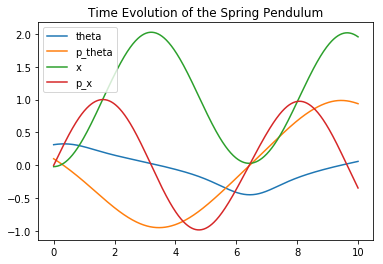

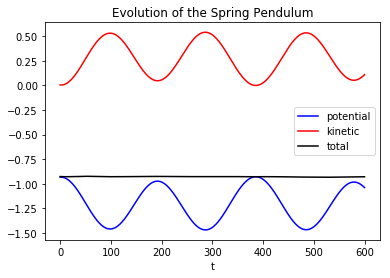

In [196]:
tt = np.arange(n_train+1)*(T/n_train)
tt = torch.Tensor(tt.reshape(-1,1))

theta = theta_0 + model_spring_pendulum(tt)[:,0].clone().reshape(-1,1) * tt
p_theta = p_theta_0 + model_spring_pendulum(tt)[:,1].clone().reshape(-1,1) * tt
x = x_0 + model_spring_pendulum(tt)[:,2].clone().reshape(-1,1) * tt
p_x = p_x_0 + model_spring_pendulum(tt)[:,3].clone().reshape(-1,1) * tt



potential = 1/2.*k* (x.detach().numpy())**2 - m*g*(L+x.detach().numpy()) * np.cos(theta.detach().numpy())
kinetic = 1/2.*m*((p_x.detach().numpy()/m)**2+ (p_theta.detach().numpy()/((L+x.detach().numpy())*m)) **2 )

total = potential + kinetic

plt.figure()
plt.title('Time Evolution of the Spring Pendulum')

plt.plot(tt.detach().numpy(), theta.detach().numpy(), label = 'theta')
plt.plot(tt.detach().numpy(), p_theta.detach().numpy(), label = 'p_theta')
plt.plot(tt.detach().numpy(), x.detach().numpy(), label = 'x')
plt.plot(tt.detach().numpy(), p_x.detach().numpy(), label = 'p_x')
plt.legend()

plt.figure()

plt.title('Evolution of the Spring Pendulum')

plt.plot(potential,color = 'b', label = 'potential')
plt.plot(kinetic, color = 'r', label = 'kinetic')
plt.plot(total, color = 'k', label = 'total')
plt.xlabel('t')
plt.legend()


#### Energy fluctuations for NN vs Euler integration:

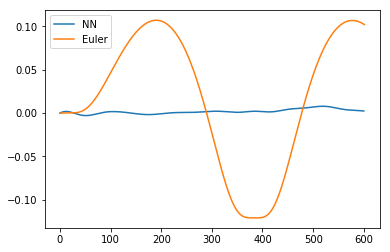

In [197]:
E0 = (total[0])
scale = int(len(total_euler)/len(total))
plt.plot((total-E0)/E0,label = 'NN')
plt.plot((total_euler[::scale]-E0)/E0, label = 'Euler')
plt.legend()

# Experiment 4: Non-separable Hamiltonian

#### https://arxiv.org/pdf/1609.02212.pdf
#### numerical experiment in Molei Tao's paper

In [242]:
Q_0 = -3
P_0 = 0
T = 4
H0 = 1/2.*(Q_0**2+1)*(P_0**2+1)
# Same as Pendulum Net..

class NonSeparableHamiltonNet(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(NonSeparableHamiltonNet, self).__init__()
        self.input = nn.Linear(D_in, H)
        
        self.fc1 = nn.Linear(H, H)
        self.fc2 = nn.Linear(H, H)
        self.out = nn.Linear(H, D_out)

    def forward(self, X):
        
        X = torch.sin(self.input(X))
        X = torch.tanh(self.fc1(X))
        X = torch.tanh(self.fc2(X))

        X = self.out(X)
        return X


In [243]:
model_non_separable_hamiltonian = NonSeparableHamiltonNet(1, 64, 4)

In [244]:
num_epochs = 1000
batch_size = 60
n_train = 600
learning_rate = 1e-4

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_non_separable_hamiltonian.parameters(), lr= learning_rate, weight_decay=1e-5)


### Note: set regularize_energy = True to add MSE loss between H(q,p) and H_0 to penalize deviation of energy
### Do this after training without this regulaization term for a few epochs(so that NN is close to the desired manifold already and need minimum changes to preserve energy)

In [251]:
# wether to constraint energy
regularize_energy = True

# Start training
for epoch in range(num_epochs):
    tt = np.random.uniform(0, T, n_train)
    tt = torch.Tensor(tt.reshape(-1,1))
    tt.requires_grad_(True)

    for i in range(int(n_train/batch_size)):
        
        tti = tt[i*batch_size:(i+1)*batch_size]
        
        # forward
        Q = Q_0 + model_non_separable_hamiltonian(tti)[:,0].clone().reshape(-1,1) * tti
        P = P_0 + model_non_separable_hamiltonian(tti)[:,1].clone().reshape(-1,1) * tti
        
        
        Q.retain_grad()
        P.retain_grad()
        
        H = 1/2.*(Q**2+1)*(P**2+1)
        
        
        ## 1. use auto diff for d_H_d_p and d_H_d_theta 
        ## 2. or precompute this from Hamiltonian
        d_H_d_Q, = torch.autograd.grad(H, Q, H.new(H.shape).fill_(1),create_graph = True)
        d_H_d_P, = torch.autograd.grad(H, P, H.new(H.shape).fill_(1),create_graph = True)

        
        d_Q_d_t, = torch.autograd.grad(Q, tti, Q.new(Q.shape).fill_(1),create_graph = True)
        d_P_d_t, = torch.autograd.grad(P, tti, P.new(P.shape).fill_(1),create_graph = True)

        loss_eqn = criterion(d_P_d_t, - d_H_d_Q) + criterion(d_Q_d_t, d_H_d_P)
        
        if(regularize_energy == True):
            loss_energy = criterion(H, H.new(H.shape).fill_(H0))
            loss = loss_eqn + 1/2. * (loss_eqn.data/loss_energy.data) * loss_energy
            
        else:
            loss = loss_eqn

        optimizer.zero_grad()
        loss.backward(retain_graph = True)
        optimizer.step()
        
                
    if( (epoch+1) % (num_epochs/10) ==0):
        print('epoch [{}/{}], loss Hamiltons equations:{:.8f}'.format(epoch + 1, num_epochs, loss.data))
        if(regularize_energy == True):
            print('epoch [{}/{}], loss energy:{:.8f}'.format(epoch + 1, num_epochs, loss_energy.data))

epoch [100/1000], loss Hamiltons equations:0.01406828
epoch [100/1000], loss energy:0.34500464
epoch [200/1000], loss Hamiltons equations:0.01039056
epoch [200/1000], loss energy:0.16333850
epoch [300/1000], loss Hamiltons equations:0.03373792
epoch [300/1000], loss energy:0.00546353
epoch [400/1000], loss Hamiltons equations:0.04363546
epoch [400/1000], loss energy:0.00682258
epoch [500/1000], loss Hamiltons equations:0.02226299
epoch [500/1000], loss energy:0.00097302
epoch [600/1000], loss Hamiltons equations:0.02149173
epoch [600/1000], loss energy:0.00434285
epoch [700/1000], loss Hamiltons equations:0.03150593
epoch [700/1000], loss energy:0.00650907
epoch [800/1000], loss Hamiltons equations:0.01899842
epoch [800/1000], loss energy:0.00054915
epoch [900/1000], loss Hamiltons equations:0.01377134
epoch [900/1000], loss energy:0.00046363
epoch [1000/1000], loss Hamiltons equations:0.01113032
epoch [1000/1000], loss energy:0.00053431


In [249]:
print(loss_eqn.data)
print(loss_energy.data)
print((loss_eqn.data/loss_energy.data) * loss_energy)

tensor(0.0143)
tensor(8.3351e-05)
tensor(0.0143, grad_fn=<MulBackward0>)


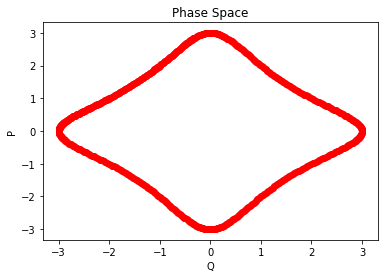

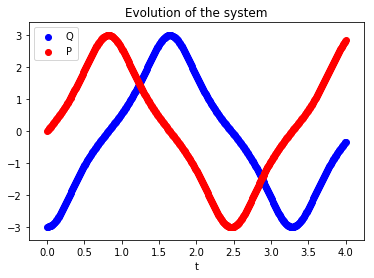

In [252]:
#tt = np.random.uniform(0, T, n_train)
Nstep = n_train
tt = np.arange(Nstep+1) * T/Nstep
tt = torch.Tensor(tt.reshape(-1,1))

Q =  Q_0 + model_non_separable_hamiltonian(tt)[:,0].clone().reshape(-1,1)*tt
P = P_0 + model_non_separable_hamiltonian(tt)[:,1].clone().reshape(-1,1)*tt

plt.figure()
plt.title('Phase Space')
plt.scatter(Q.detach().numpy(), P.detach().numpy(),color = 'r')
plt.xlabel('Q')
plt.ylabel('P')

H_test = 1/2.*(Q**2+1)*(P**2+1)

plt.figure()
plt.title('Evolution of the system')
plt.scatter(tt, Q.detach().numpy(),color = 'b', label = 'Q')
plt.scatter(tt, P.detach().numpy(),color = 'r', label = 'P')
plt.xlabel('t')
plt.legend()


#### above are the result of 2000 epochs of traning without energy penalty and 1000 epochs with energy pengalty

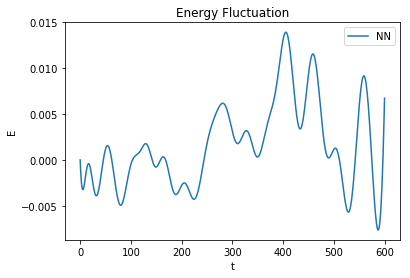

In [255]:
plt.figure()
plt.title('Energy Fluctuation')
plt.xlabel('t')
plt.ylabel('E')
E = 1/2.*(Q.detach().numpy()**2+1)*(P.detach().numpy()**2+1)

E0 = (E[0])
plt.plot((E-E0)/E0, label = 'NN')
plt.legend()

#### Error analysis? 
#### Energy conservation does not imply accurcy;
#### error in energy + error in hamilton's equation both need to be considered